# Short term variability in DP2 

Can we measure short term variability (less than 1 wee) of AGN, using data from Rubin Data Preview 2. 

Planning document: https://docs.google.com/document/d/1U_OuIQrjCqC4iLNAIK9sChxuAPEEr-aRlTw1PRORF8Q 

### Imports

In [48]:
# --- stdlib ---
import os
import warnings
import logging

# --- environment (must be first) ---
os.environ.setdefault("NUMEXPR_MAX_THREADS", "64")

# --- third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

import pyarrow.parquet as pq
from upath import UPath
import s3fs

# --- project ---
import lsdb
import nested_pandas 
from lsdb import ConeSearch
from nested_pandas import NestedFrame, read_parquet
from nested_pandas.datasets import generate_parquet_file

# --- global configuration ---
warnings.simplefilter("ignore")

logging.getLogger("numexpr").setLevel(logging.WARNING)
logging.getLogger("distributed").setLevel(logging.WARNING)

dask.config.set({"dataframe.convert-string": False})

# --- diagnostics ---
print(f"lsdb version: {lsdb.__version__}")

lsdb version: 0.7.3


In [2]:
# set up Dask client for parallel computing

os.environ.setdefault("JUPYTERHUB_PUBLIC_URL", "http://127.0.0.1")
client = Client(n_workers=4, threads_per_worker=1, memory_limit="64GB");
# Print the dashboard link and port
print(f"Dask is running at: {client.dashboard_link}")

Dask is running at: http://127.0.0.1proxy/8787/status


In [3]:
# Set up S3 filesystem access - I need this to access IRSA ZTF data from SLAC machines

fs = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

print(fs.s3.meta.endpoint_url)
print(fs.ls("ipac-irsa-ztf/contributed/dr23/objects/hats")[:5])

https://s3.us-east-1.amazonaws.com
['ipac-irsa-ztf/contributed/dr23/objects/hats/collection.properties', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats_index_oid', 'ipac-irsa-ztf/contributed/dr23/objects/hats/ztf_dr23_objects-hats_margin_10arcsec']


## 1. Creating crossmatched dataset

## 1.1. Import raw data

In [5]:
# Import the ZTF DR23 object HATS catalog
path = UPath(
    "s3://ipac-irsa-ztf/contributed/dr23/objects/hats",
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

obj_ZTF_23 = lsdb.open_catalog(path, columns=['oid', 'ra', 'dec', 'ngoodobs', 'weightedmagrms', 'medianabsdev', 'vonneumannratio', 'fid', 'medianmag' ])
obj_ZTF_23

,oid,ra,dec,ngoodobs,weightedmagrms,medianabsdev,vonneumannratio,fid,medianmag
npartitions=1791,,,,,,,,,
"Order: 3, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],float[pyarrow]
"Order: 3, Pixel: 1",...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3070",...,...,...,...,...,...,...,...,...
"Order: 4, Pixel: 3071",...,...,...,...,...,...,...,...,...


In [6]:
# Import Rubin DP1 HATS object catalog
obj_DP1 = lsdb.open_catalog('/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/object_collection', columns=['objectId', 'coord_ra', 'coord_dec'])
obj_DP1

,objectId,coord_ra,coord_dec
npartitions=389,,,
"Order: 6, Pixel: 130",int64[pyarrow],double[pyarrow],double[pyarrow]
"Order: 8, Pixel: 2176",...,...,...
...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...
"Order: 7, Pixel: 143884",...,...,...


## 1.2. Crossmatch

In [7]:
DP1_ZTF_xmatch_plan = lsdb.crossmatch(obj_DP1, obj_ZTF_23, radius_arcsec=0.1)

In [8]:
# takes around 5 minutes
DP1_ZTF_xmatch = DP1_ZTF_xmatch_plan.compute()

## 1.3. Investigate the properties of the crossmatch

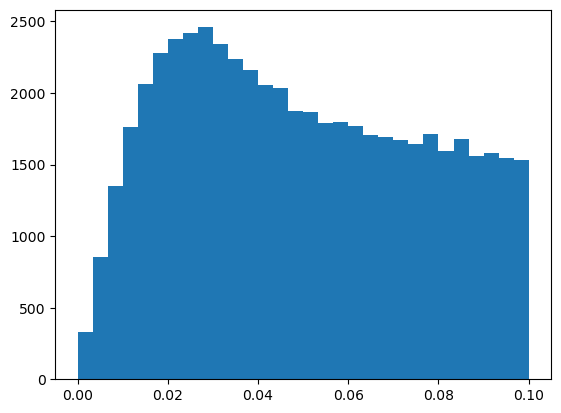

In [9]:
# there are 54000 lightcurves in ZTF DR23 that match to DP1 objects within 0.1 arcsec
plt.hist(DP1_ZTF_xmatch['_dist_arcsec'], bins=30);

In [34]:
# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45),  # Fornax Dwarf Spheroidal Galaxy
    "Seagull": (106.30, -10.51)  # Seagull Nebula
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 2 * 3600  # Convert 2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

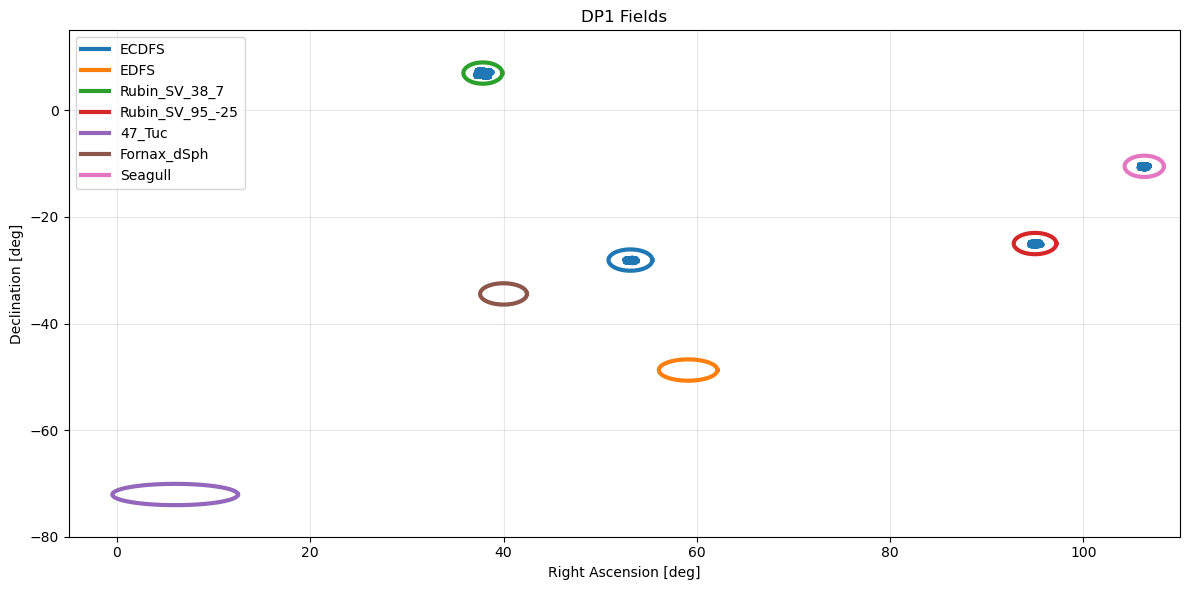

In [37]:

radius_deg = radius_arcsec / 3600.0  # 2 deg
theta = np.linspace(0, 2 * np.pi, 512)

fig, ax = plt.subplots(figsize=(12, 6))

# Background points: wrap RA to [-180, 180]
ra_bg = DP1_ZTF_xmatch["coord_ra_object_lc"].to_numpy()
ra_bg = ((ra_bg + 180) % 360) - 180
dec_bg = DP1_ZTF_xmatch["coord_dec_object_lc"].to_numpy()

ax.scatter(
    ra_bg,
    dec_bg,
    s=1,
    alpha=0.3,
    rasterized=True,
)

# Field circles
for name, (ra0, dec0) in fields.items():
    dec0_rad = np.deg2rad(dec0)

    ra = ra0 + (radius_deg * np.cos(theta)) / np.cos(dec0_rad)
    dec = dec0 + radius_deg * np.sin(theta)

    # wrap circle RA to [-180, 180]
    ra = ((ra + 180) % 360) - 180

    ax.plot(
        ra,
        dec,
        linewidth=3,
        label=name,
    )

# Axes formatting
ax.set_xlim(-5, 110)
ax.set_ylim(-80, 15)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")
ax.set_title("DP1 Fields")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.show()

In [ ]:
DP1_ZTF_xmatch

,objectId_object_lc,coord_ra_object_lc,coord_dec_object_lc,oid_ZTF_DR23_Objects,ra_ZTF_DR23_Objects,dec_ZTF_DR23_Objects,ngoodobs_ZTF_DR23_Objects,weightedmagrms_ZTF_DR23_Objects,medianabsdev_ZTF_DR23_Objects,vonneumannratio_ZTF_DR23_Objects,fid_ZTF_DR23_Objects,medianmag_ZTF_DR23_Objects,_dist_arcsec
_healpix_29,,,,,,,,,,,,,
9193771653802800,648369431235265644,38.167419,5.994349,452212100027729,38.167412,5.994326,7,<NA>,0.160378,2.37314,2,21.591194,0.084487
9193815210727380,648369362515787792,38.181318,6.000302,452212100003724,38.181299,6.000286,230,<NA>,0.129782,1.873368,2,20.751823,0.090454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530270978491866923,611257134226605931,53.258119,-27.422548,1246209400004589,53.25811,-27.422557,14,<NA>,0.069035,1.795617,2,20.68195,0.04253
2530271075840175194,611257134226605939,53.240364,-27.412332,252102300009315,53.240348,-27.412339,1,<NA>,0.0,0.0,1,20.712673,0.056657


In [ ]:
# Save the crossmatch to a parquet file
DP1_ZTF_xmatch.to_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/DP1_ZTF_DR23_xmatch_v1.parquet')

# 2. Selection and filtering of the object-level dataset

In [ ]:
# read the data back in
DP1_ZTF_xmatch = pq.read_table('/sdf/home/n/ncaplar/github/short_var_AGN/DP1_ZTF_DR23_xmatch_v1.parquet').to_pandas()

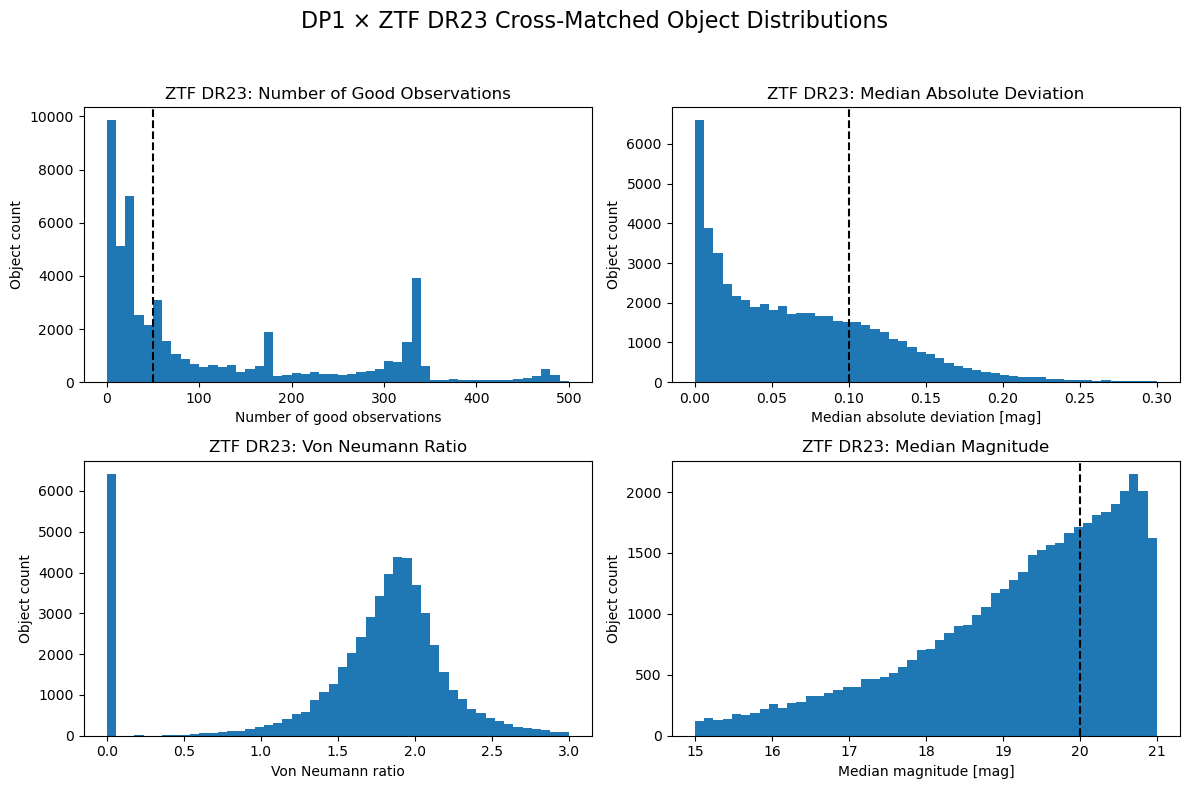

In [39]:
plt.figure(figsize=(12, 8))

# 1. Number of good ZTF observations
plt.subplot(2, 2, 1)
plt.hist(
    DP1_ZTF_xmatch["ngoodobs_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 500),
)
plt.axvline(50, linestyle="--", color='black')
plt.title("ZTF DR23: Number of Good Observations")
plt.xlabel("Number of good observations")
plt.ylabel("Object count")

# 2. Median absolute deviation
plt.subplot(2, 2, 2)
plt.hist(
    DP1_ZTF_xmatch["medianabsdev_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 0.3),
)
plt.axvline(0.1, linestyle="--", color='black')
plt.title("ZTF DR23: Median Absolute Deviation")
plt.xlabel("Median absolute deviation [mag]")
plt.ylabel("Object count")

# 3. Von Neumann ratio
plt.subplot(2, 2, 3)
plt.hist(
    DP1_ZTF_xmatch["vonneumannratio_ZTF_DR23_Objects"],
    bins=50,
    range=(0, 3),
)

plt.title("ZTF DR23: Von Neumann Ratio")
plt.xlabel("Von Neumann ratio")
plt.ylabel("Object count")

# 4. Median magnitude
plt.subplot(2, 2, 4)
plt.hist(
    DP1_ZTF_xmatch["medianmag_ZTF_DR23_Objects"],
    bins=50,
    range=(15, 21),
)
plt.axvline(20, linestyle="--", color='black')
plt.title("ZTF DR23: Median Magnitude")
plt.xlabel("Median magnitude [mag]")
plt.ylabel("Object count")

plt.suptitle(
    "DP1 × ZTF DR23 Cross-Matched Object Distributions",
    fontsize=16,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [40]:
# some sort of selection
DP1_ZTF_first_selection = DP1_ZTF_xmatch[(DP1_ZTF_xmatch['ngoodobs_ZTF_DR23_Objects']>50)  & (DP1_ZTF_xmatch['medianabsdev_ZTF_DR23_Objects']>0.1) & (DP1_ZTF_xmatch['medianmag_ZTF_DR23_Objects']<20)]

In [41]:
DP1_ZTF_first_selection

,objectId_object_lc,coord_ra_object_lc,coord_dec_object_lc,oid_ZTF_DR23_Objects,ra_ZTF_DR23_Objects,dec_ZTF_DR23_Objects,ngoodobs_ZTF_DR23_Objects,weightedmagrms_ZTF_DR23_Objects,medianabsdev_ZTF_DR23_Objects,vonneumannratio_ZTF_DR23_Objects,fid_ZTF_DR23_Objects,medianmag_ZTF_DR23_Objects,_dist_arcsec
_healpix_29,,,,,,,,,,,,,
9195137144744337,648361940812301490,38.037332,6.026792,452312100002879,38.037345,6.026793,97,<NA>,0.10388,1.647239,3,19.903639,0.044714
9195521370441204,648370049710560226,38.197418,6.037594,452312100002806,38.197423,6.037614,102,<NA>,0.101194,2.10541,3,19.820129,0.074235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530267434394379825,611257134226611503,53.112455,-27.494148,252102300001154,53.112459,-27.494163,227,<NA>,0.118277,1.551483,1,18.752029,0.055753
2530268181837610521,611257134226612008,53.137403,-27.479286,252202300002511,53.137398,-27.479279,125,<NA>,0.145218,1.801728,2,19.973087,0.02789


## 3. Get lightcurves for the first selection of objects

In [42]:
# load the lightcurves for ZTF DR23
path = UPath(
    's3://ipac-irsa-ztf/contributed/dr23/lc/hats',
    anon=True,
    client_kwargs={
        "region_name": "us-east-1",
        "endpoint_url": "https://s3.us-east-1.amazonaws.com",
    },
)

lc_ZTF_23 = lsdb.open_catalog(path)
lc_ZTF_23

,objectid,filterid,objra,objdec,lightcurve
npartitions=9933,,,,,
"Order: 4, Pixel: 0",int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [..."
"Order: 4, Pixel: 1",...,...,...,...,...
...,...,...,...,...,...
"Order: 5, Pixel: 12286",...,...,...,...,...
"Order: 5, Pixel: 12287",...,...,...,...,...


In [ ]:
# perform crossmatch between selected DP1_ZTF objects and lightcurves
# seems silly to do crossmatch rather then join or index search
ZTF_DP1_lc_plan = lsdb.crossmatch(DP1_ZTF_first_selection, lc_ZTF_23, radius_arcsec=0.01, ra_column='coord_ra_object_lc', dec_column='coord_dec_object_lc')

In [28]:
ZTF_DP1_lc = ZTF_DP1_lc_plan.compute()

In [ ]:
# Save the lightcurve crossmatch to a parquet file
ZTF_DP1_lc.to_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/ZTF_DP1_lc.parquet')

# Analysis

In [49]:
# Save the lightcurve crossmatch to a parquet file
ZTF_DP1_lc = read_parquet('/sdf/home/n/ncaplar/github/short_var_AGN/ZTF_DP1_lc.parquet')

### 4.1. Single lightcurve

In [51]:
single_lc = ZTF_DP1_lc.iloc[0]['lightcurve_ZTF_DR23_Lightcurves']
single_lc

,hmjd,mag,magerr,clrcoeff,catflags
0,58397.32573,19.776203,0.133708,0.181281,0
1,58423.26074,20.024807,0.154935,0.181899,0
...,...,...,...,...,...
57,60575.39503,19.822823,0.137675,0.180148,0
58,60576.46568,19.758467,0.132206,0.192202,0


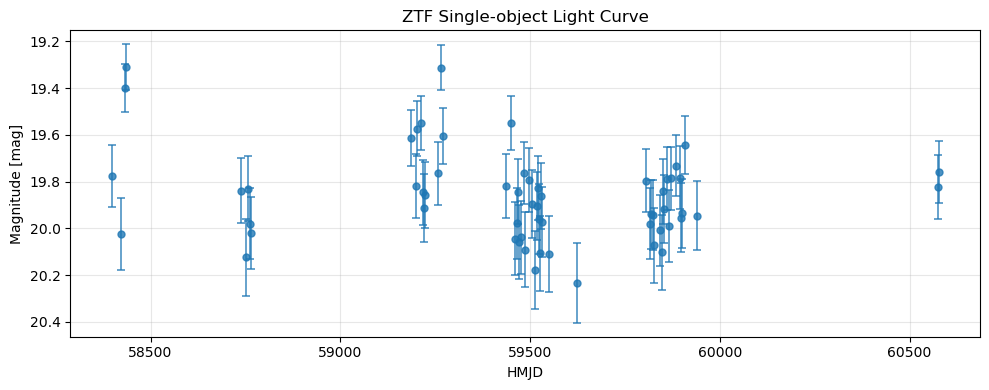

In [54]:
plt.figure(figsize=(10, 4))

plt.errorbar(
    single_lc["hmjd"],
    single_lc["mag"],
    yerr=single_lc["magerr"],
    fmt="o",
    ms=5,
    elinewidth=1.2,
    capsize=3,
    capthick=1.2,
    alpha=0.8,
)

plt.xlabel("HMJD")
plt.ylabel("Magnitude [mag]")
plt.title("ZTF Single-object Light Curve")

plt.gca().invert_yaxis()  # magnitudes: brighter = up
plt.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()